[*********************100%***********************]  1 of 1 completed


Annualized Sharpe Ratio: 0.34
Maximum Drawdown: -16.95%


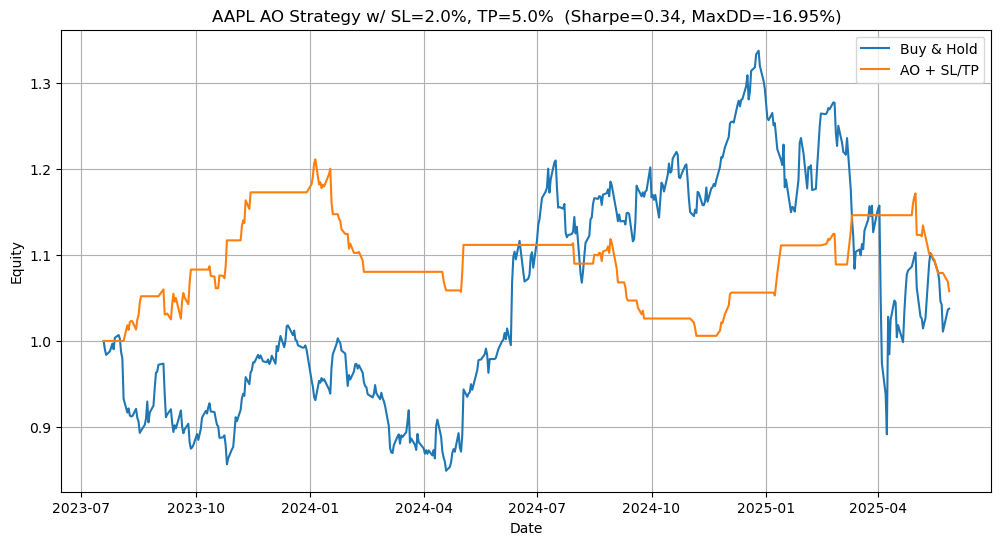

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 参数
ticker          = "AAPL"
period          = "2y"
interval        = "1d"
stop_loss_pct   = 0.02    # 2% 止损
take_profit_pct = 0.05    # 5% 止盈

# 2. 下载数据
df = yf.download(ticker, period=period, interval=interval)

# 3. 扁平化 MultiIndex（如果存在）
if isinstance(df.columns, pd.MultiIndex):
    # 默认 group_by='column' 时，level0 是属性，level1 是 ticker
    # 所以取 level0：
    df.columns = df.columns.get_level_values(0)
    # 或者也可以：df.columns = df.columns.droplevel(1)

# 4. 只保留我们要用的四列并去掉 NaN
df = df[['Open','High','Low','Close']].copy()
df.dropna(inplace=True)

# 5. 计算 AO 基线信号
df['median_price'] = (df['High'] + df['Low']) / 2
df['ao_fast']      = df['median_price'].rolling(5).mean()
df['ao_slow']      = df['median_price'].rolling(34).mean()
df['AO']           = df['ao_fast'] - df['ao_slow']
df['AO_prev']      = df['AO'].shift(1)
df.dropna(inplace=True)

df['signal'] = 0
df.loc[(df['AO'] > 0) & (df['AO_prev'] <= 0), 'signal'] =  1
df.loc[(df['AO'] < 0) & (df['AO_prev'] >= 0), 'signal'] = -1

# 6. 回测：逐日循环检测止损/止盈
df['strategy_return'] = 0.0
position    = 0
entry_price = np.nan

for i in range(1, len(df)):
    date       = df.index[i]
    prev_close = df['Close'].iloc[i-1]
    today_open = df['Open'].iloc[i]
    high       = df['High'].iloc[i]
    low        = df['Low'].iloc[i]
    sig        = df['signal'].iloc[i]

    # 未持仓，根据信号开仓
    if position == 0 and sig != 0:
        position    = sig
        entry_price = today_open
        if position == 1:
            df.at[date, 'strategy_return'] = df['Close'].iloc[i] / entry_price - 1
        else:
            df.at[date, 'strategy_return'] = entry_price / df['Close'].iloc[i] - 1

    # 多头持仓：检测止损/止盈或持有
    elif position == 1:
        sl_price = entry_price * (1 - stop_loss_pct)
        tp_price = entry_price * (1 + take_profit_pct)
        if low <= sl_price:
            df.at[date, 'strategy_return'] = sl_price / prev_close - 1
            position = 0
        elif high >= tp_price:
            df.at[date, 'strategy_return'] = tp_price / prev_close - 1
            position = 0
        else:
            df.at[date, 'strategy_return'] = df['Close'].iloc[i] / prev_close - 1

    # 空头持仓：检测止损/止盈或持有
    elif position == -1:
        sl_price = entry_price * (1 + stop_loss_pct)
        tp_price = entry_price * (1 - take_profit_pct)
        if high >= sl_price:
            df.at[date, 'strategy_return'] = prev_close / sl_price - 1
            position = 0
        elif low <= tp_price:
            df.at[date, 'strategy_return'] = prev_close / tp_price - 1
            position = 0
        else:
            df.at[date, 'strategy_return'] = -(df['Close'].iloc[i] / prev_close - 1)

# 7. 构建净值 & 统计指标
df['equity_curve']   = (1 + df['strategy_return']).cumprod()
df['buy_hold_curve'] = (1 + df['Close'].pct_change()).cumprod().fillna(1)

sharpe = df['strategy_return'].mean() / df['strategy_return'].std() * np.sqrt(252)
cum_max = df['equity_curve'].cummax()
drawdown = df['equity_curve'] / cum_max - 1
max_dd = drawdown.min()

print(f"Annualized Sharpe Ratio: {sharpe:.2f}")
print(f"Maximum Drawdown: {max_dd:.2%}")

# 8. 绘图对比
plt.figure(figsize=(12,6))
plt.plot(df.index, df['buy_hold_curve'], label='Buy & Hold')
plt.plot(df.index, df['equity_curve'],    label='AO + SL/TP')
plt.title(f"{ticker} AO Strategy w/ SL={stop_loss_pct*100:.1f}%, TP={take_profit_pct*100:.1f}%  "
          f"(Sharpe={sharpe:.2f}, MaxDD={max_dd:.2%})")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.legend()
plt.grid(True)
plt.show()
